In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
from icecream import ic

from sklearn.decomposition import PCA
import torch.optim as optim

import random

import matplotlib.pyplot as plt


device = "mps" if torch.backends.mps.is_available() else "cpu"
ic(device);

ic| device: 'mps'


In [3]:
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


In [4]:
# Load the Zachary Karate Club graph
G = nx.karate_club_graph()
num_nodes = G.number_of_nodes()


In [13]:
def get_alias_edge(G, src, dst, p, q):
    """Compute transition probabilities for neighbors of 'dst' based on Node2Vec bias."""
    unnormalized_probs = []
    for neighbor in G[dst]:
        if neighbor == src:
            weight = 1.0 / p
        elif G.has_edge(neighbor, src):
            weight = 1.0
        else:
            weight = 1.0 / q
        unnormalized_probs.append(weight)
    norm_const = sum(unnormalized_probs)
    normalized_probs = [w / norm_const for w in unnormalized_probs]
    return list(G[dst]), normalized_probs


def node2vec_walk(G, start, walk_length, p, q):
    """Generate a random walk starting from the given node."""
    walk = [start]
    while len(walk) < walk_length:
        cur = walk[-1]
        neighbors = list(G.neighbors(cur))
        if len(neighbors) == 0:
            break
        if len(walk) == 1:
            next_node = random.choice(neighbors)
        else:
            prev = walk[-2]
            candidates, probs = get_alias_edge(G, prev, cur, p, q)
            next_node = random.choices(candidates, weights=probs, k=1)[0]
        walk.append(next_node)
    return walk


nodes = list(G.nodes())
node = nodes[0]
ic(node)
for i in range(10):
    walk = node2vec_walk(G, start=node, walk_length=10, p=1, q=1)
    ic(walk)

ic| node: 0
ic| walk: [0, 11, 0, 7, 2, 1, 21, 0, 5, 10]
ic| walk: [0, 12, 0, 12, 0, 31, 25, 31, 0, 21]
ic| walk: [0, 17, 0, 4, 10, 0, 1, 13, 0, 13]
ic| walk: [0, 2, 7, 2, 27, 24, 27, 2, 1, 21]
ic| walk: [0, 2, 13, 2, 7, 2, 8, 0, 13, 3]
ic| walk: [0, 11, 0, 2, 9, 33, 28, 31, 33, 23]
ic| walk: [0, 4, 0, 17, 0, 11, 0, 19, 33, 19]
ic| walk: [0, 19, 0, 1, 13, 1, 30, 8, 0, 12]
ic| walk: [0, 4, 10, 5, 0, 2, 9, 33, 9, 2]
ic| walk: [0, 8, 30, 33, 15, 32, 30, 33, 31, 25]


In [ ]:
# Generate random walks for all nodes

# Node2Vec parameters
p = 1.0
q = 1.0
walk_length = 10
num_walks = 10
walks = []
for _ in range(num_walks):
    nodes = list(G.nodes())
    random.shuffle(nodes)
    for node in nodes:
        walk = node2vec_walk(G, node, walk_length, p, q)
        walks.append(walk)


Using device: mps
Epoch 10, Loss: 1.9448
Epoch 20, Loss: 1.9455
Epoch 30, Loss: 1.9412
Epoch 40, Loss: 1.9355
Epoch 50, Loss: 1.9385
Epoch 60, Loss: 1.9352
Epoch 70, Loss: 1.9410
Epoch 80, Loss: 1.9390
Epoch 90, Loss: 1.9320
Epoch 100, Loss: 1.9464

Learned embeddings:
Node 0: [-0.39784876 -0.10037155  0.36428046  0.33910775 -0.9396972   0.8479562
  0.58180153 -0.11135224  0.10276927 -0.12751383  0.07395329  0.18825679
 -0.47200906  0.6404113  -0.3034547   0.41798705]
Node 1: [-0.54123664  0.51017624  0.52953696  0.6523416  -0.16852173  0.68000513
  1.1010289  -0.00638974 -0.39836645  0.89346117 -0.06930356  1.6636235
 -0.25710982  0.67334473 -0.12432358  0.00616604]
Node 2: [-1.5413933   0.5466617   0.420876    0.47642332  0.20124696 -0.07936399
  0.4144282  -0.0876025   0.33165202 -0.06580546  0.15098712  0.8280409
 -0.21460588 -0.28932986 -0.60366285  0.5857741 ]
Node 3: [-0.57811975  0.38264352  0.33029222  0.42872307 -0.37558937  0.38973784
  1.3072366  -0.07389258  0.3253857   1.

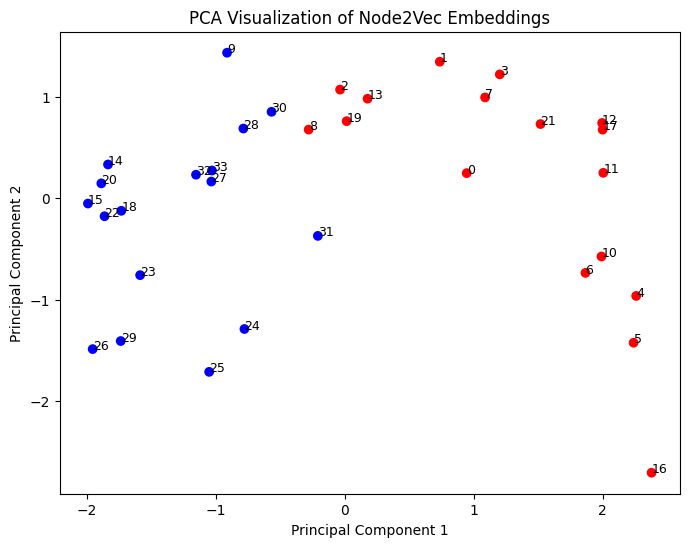

In [ ]:
window_size = 2
embedding_dim = 16
num_negative_samples = 5


# Create training pairs using a sliding window over each walk
pairs = []
for walk in walks:
    for i, target in enumerate(walk):
        start = max(0, i - window_size)
        end = min(len(walk), i + window_size + 1)
        for j in range(start, end):
            if i != j:
                pairs.append((target, walk[j]))
pairs = np.array(pairs)


# Define the Node2Vec Skip-Gram model
class Node2Vec(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(Node2Vec, self).__init__()
        self.in_embeddings = nn.Embedding(num_nodes, embedding_dim)
        self.out_embeddings = nn.Embedding(num_nodes, embedding_dim)
        nn.init.xavier_uniform_(self.in_embeddings.weight)
        nn.init.xavier_uniform_(self.out_embeddings.weight)

    def forward(self, target, context, negative):
        embed_target = self.in_embeddings(target)  # (batch, embedding_dim)
        embed_context = self.out_embeddings(context)  # (batch, embedding_dim)
        score = torch.sum(embed_target * embed_context, dim=1)
        log_target = torch.log(torch.sigmoid(score) + 1e-10)

        embed_negative = self.out_embeddings(
            negative
        )  # (batch, num_negative, embedding_dim)
        neg_score = torch.bmm(embed_negative, embed_target.unsqueeze(2)).squeeze()
        log_negative = torch.sum(torch.log(torch.sigmoid(-neg_score) + 1e-10), dim=1)

        loss = -(log_target + log_negative)
        return loss.mean()


model = Node2Vec(num_nodes, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
batch_size = 64
num_batches = len(pairs) // batch_size + 1

for epoch in range(num_epochs):
    np.random.shuffle(pairs)
    epoch_loss = 0
    for i in range(0, len(pairs), batch_size):
        batch = pairs[i : i + batch_size]
        target_batch = torch.LongTensor(batch[:, 0]).to(device)
        context_batch = torch.LongTensor(batch[:, 1]).to(device)
        negative_batch = torch.LongTensor(
            np.random.randint(0, num_nodes, size=(len(batch), num_negative_samples))
        ).to(device)

        optimizer.zero_grad()
        loss = model(target_batch, context_batch, negative_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss / num_batches:.4f}")

# Retrieve learned embeddings
embeddings = model.in_embeddings.weight.data.cpu().numpy()
print("\nLearned embeddings:")
for node in range(num_nodes):
    print(f"Node {node}: {embeddings[node]}")

# Use PCA to reduce the embeddings to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Create colors list based on club membership: red for 'Mr. Hi', blue for others.
colors = []
for node in range(num_nodes):
    club = G.nodes[node]["club"]
    colors.append("red" if club == "Mr. Hi" else "blue")

# Plotting the PCA visualization
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
for i in range(num_nodes):
    plt.annotate(str(i), (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)
plt.title("PCA Visualization of Node2Vec Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## gemini

Using device: mps


Epoch 1/50: 100%|██████████| 1807/1807 [00:04<00:00, 362.96it/s]


Epoch 1/50, Loss: 1.3812841042991757


Epoch 2/50: 100%|██████████| 1807/1807 [00:03<00:00, 491.31it/s]


Epoch 2/50, Loss: 1.376141531918928


Epoch 3/50: 100%|██████████| 1807/1807 [00:03<00:00, 496.67it/s]


Epoch 3/50, Loss: 1.3759483701630948


Epoch 4/50: 100%|██████████| 1807/1807 [00:03<00:00, 505.28it/s]


Epoch 4/50, Loss: 1.377311100727432


Epoch 5/50: 100%|██████████| 1807/1807 [00:03<00:00, 492.36it/s]


Epoch 5/50, Loss: 1.3767157481160275


Epoch 6/50: 100%|██████████| 1807/1807 [00:03<00:00, 486.42it/s]


Epoch 6/50, Loss: 1.3720891716604349


Epoch 7/50: 100%|██████████| 1807/1807 [00:03<00:00, 515.72it/s]


Epoch 7/50, Loss: 1.3798854574148574


Epoch 8/50: 100%|██████████| 1807/1807 [00:03<00:00, 532.70it/s]


Epoch 8/50, Loss: 1.375138282973901


Epoch 9/50: 100%|██████████| 1807/1807 [00:03<00:00, 527.76it/s]


Epoch 9/50, Loss: 1.372982275446388


Epoch 10/50: 100%|██████████| 1807/1807 [00:03<00:00, 530.77it/s]


Epoch 10/50, Loss: 1.379632944416498


Epoch 11/50: 100%|██████████| 1807/1807 [00:03<00:00, 501.36it/s]


Epoch 11/50, Loss: 1.3757944806733664


Epoch 12/50: 100%|██████████| 1807/1807 [00:03<00:00, 529.37it/s]


Epoch 12/50, Loss: 1.3774814407030742


Epoch 13/50: 100%|██████████| 1807/1807 [00:03<00:00, 554.58it/s]


Epoch 13/50, Loss: 1.3776856358199157


Epoch 14/50: 100%|██████████| 1807/1807 [00:03<00:00, 549.97it/s]


Epoch 14/50, Loss: 1.3734584816402506


Epoch 15/50: 100%|██████████| 1807/1807 [00:03<00:00, 537.37it/s]


Epoch 15/50, Loss: 1.3767400545667308


Epoch 16/50: 100%|██████████| 1807/1807 [00:03<00:00, 508.13it/s]


Epoch 16/50, Loss: 1.3766433988694733


Epoch 17/50: 100%|██████████| 1807/1807 [00:03<00:00, 541.97it/s]


Epoch 17/50, Loss: 1.37418589421681


Epoch 18/50: 100%|██████████| 1807/1807 [00:03<00:00, 536.52it/s]


Epoch 18/50, Loss: 1.372426487480683


Epoch 19/50: 100%|██████████| 1807/1807 [00:03<00:00, 535.95it/s]


Epoch 19/50, Loss: 1.379715994809025


Epoch 20/50: 100%|██████████| 1807/1807 [00:03<00:00, 521.12it/s]


Epoch 20/50, Loss: 1.3792267798849382


Epoch 21/50: 100%|██████████| 1807/1807 [00:03<00:00, 543.01it/s]


Epoch 21/50, Loss: 1.3748291289621546


Epoch 22/50: 100%|██████████| 1807/1807 [00:03<00:00, 557.58it/s]


Epoch 22/50, Loss: 1.3761418020210392


Epoch 23/50: 100%|██████████| 1807/1807 [00:03<00:00, 549.96it/s]


Epoch 23/50, Loss: 1.3769184865824804


Epoch 24/50: 100%|██████████| 1807/1807 [00:03<00:00, 551.20it/s]


Epoch 24/50, Loss: 1.3752320298588818


Epoch 25/50: 100%|██████████| 1807/1807 [00:03<00:00, 552.46it/s]


Epoch 25/50, Loss: 1.3766816362722107


Epoch 26/50: 100%|██████████| 1807/1807 [00:03<00:00, 524.37it/s]


Epoch 26/50, Loss: 1.3806616826970977


Epoch 27/50: 100%|██████████| 1807/1807 [00:03<00:00, 526.22it/s]


Epoch 27/50, Loss: 1.3747811397312752


Epoch 28/50: 100%|██████████| 1807/1807 [00:03<00:00, 537.12it/s]


Epoch 28/50, Loss: 1.3821320199095133


Epoch 29/50: 100%|██████████| 1807/1807 [00:03<00:00, 519.58it/s]


Epoch 29/50, Loss: 1.375987089485557


Epoch 30/50: 100%|██████████| 1807/1807 [00:03<00:00, 523.97it/s]


Epoch 30/50, Loss: 1.3750892892100355


Epoch 31/50: 100%|██████████| 1807/1807 [00:03<00:00, 536.75it/s]


Epoch 31/50, Loss: 1.3748656252557918


Epoch 32/50: 100%|██████████| 1807/1807 [00:03<00:00, 539.89it/s]


Epoch 32/50, Loss: 1.3755656576499855


Epoch 33/50: 100%|██████████| 1807/1807 [00:03<00:00, 530.81it/s]


Epoch 33/50, Loss: 1.381294472999087


Epoch 34/50: 100%|██████████| 1807/1807 [00:03<00:00, 535.27it/s]


Epoch 34/50, Loss: 1.3772632915976304


Epoch 35/50: 100%|██████████| 1807/1807 [00:03<00:00, 541.01it/s]


Epoch 35/50, Loss: 1.3762437494622248


Epoch 36/50: 100%|██████████| 1807/1807 [00:03<00:00, 543.96it/s]


Epoch 36/50, Loss: 1.3764172481540033


Epoch 37/50: 100%|██████████| 1807/1807 [00:03<00:00, 536.86it/s]


Epoch 37/50, Loss: 1.3781267145147356


Epoch 38/50: 100%|██████████| 1807/1807 [00:03<00:00, 542.98it/s]


Epoch 38/50, Loss: 1.3804569812708123


Epoch 39/50: 100%|██████████| 1807/1807 [00:03<00:00, 538.10it/s]


Epoch 39/50, Loss: 1.3752115325278222


Epoch 40/50: 100%|██████████| 1807/1807 [00:03<00:00, 542.75it/s]


Epoch 40/50, Loss: 1.3787183731893369


Epoch 41/50: 100%|██████████| 1807/1807 [00:03<00:00, 539.62it/s]


Epoch 41/50, Loss: 1.3751953590087849


Epoch 42/50: 100%|██████████| 1807/1807 [00:03<00:00, 537.46it/s]


Epoch 42/50, Loss: 1.376407912403246


Epoch 43/50: 100%|██████████| 1807/1807 [00:03<00:00, 532.69it/s]


Epoch 43/50, Loss: 1.378366047823812


Epoch 44/50: 100%|██████████| 1807/1807 [00:03<00:00, 535.23it/s]


Epoch 44/50, Loss: 1.3758201245981725


Epoch 45/50: 100%|██████████| 1807/1807 [00:03<00:00, 539.50it/s]


Epoch 45/50, Loss: 1.3749759381395639


Epoch 46/50: 100%|██████████| 1807/1807 [00:03<00:00, 538.01it/s]


Epoch 46/50, Loss: 1.3761256430896283


Epoch 47/50: 100%|██████████| 1807/1807 [00:03<00:00, 533.70it/s]


Epoch 47/50, Loss: 1.376648669557054


Epoch 48/50: 100%|██████████| 1807/1807 [00:03<00:00, 538.70it/s]


Epoch 48/50, Loss: 1.377453518072236


Epoch 49/50: 100%|██████████| 1807/1807 [00:03<00:00, 528.85it/s]


Epoch 49/50, Loss: 1.3786526456359744


Epoch 50/50: 100%|██████████| 1807/1807 [00:03<00:00, 549.18it/s]


Epoch 50/50, Loss: 1.3801155630272224


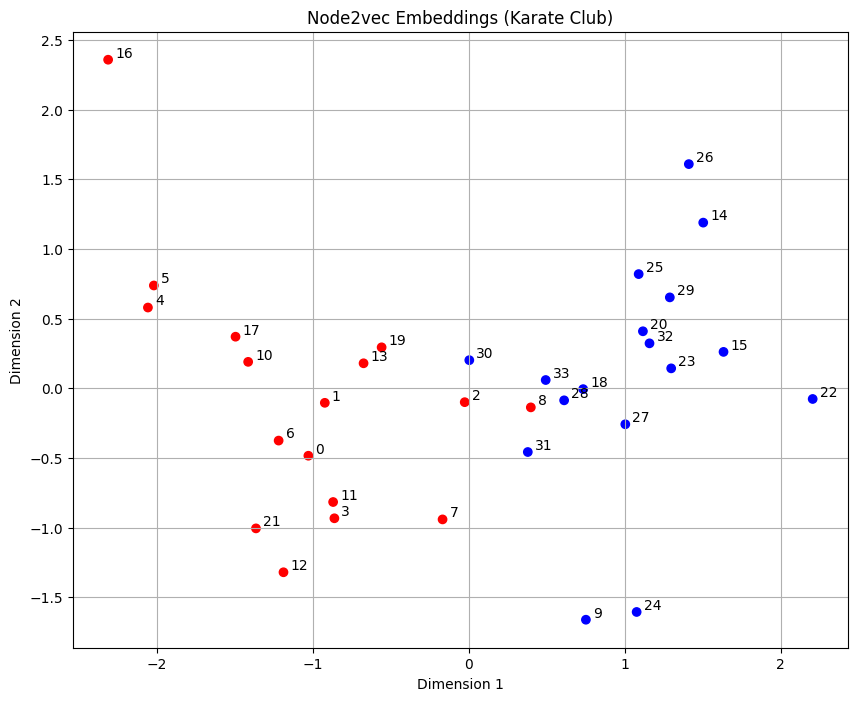

First 5 Node Embeddings:
[[-1.17535025e-01 -4.17890579e-01 -6.73701391e-02 -5.15315011e-02
  -1.73685141e-02 -4.97167856e-02 -4.03606631e-02 -8.10505301e-02
  -1.12670295e-01 -1.69396736e-02  1.35743663e-01  6.08847290e-03
  -6.60297573e-02 -5.52750193e-04  9.33401212e-02  1.63231213e-02
  -1.58582613e-01 -1.80966571e-01  2.01164007e-01 -6.02326430e-02
  -4.44611534e-04  5.18744159e-03  1.98598597e-02  3.79538834e-02
   1.14783740e+00 -1.94267645e-01 -8.02791268e-02 -5.13604134e-02
   4.48367819e-02 -3.92063335e-03 -1.13026053e-01 -1.32672399e-01
  -5.57721928e-02  4.35805023e-02  4.38855253e-02  1.75349623e-01
   4.73011360e-02  1.13784112e-01 -5.53729311e-02  3.78181934e-02
   7.70086646e-02 -8.98333546e-03  5.41527271e-02 -1.62526876e-01
   1.04906760e-01  3.05522103e-02 -2.61384621e-03  2.99204923e-02
   5.23607805e-02  6.12756796e-02  5.06441435e-03  8.89702365e-02
  -2.20757108e-02 -4.15435061e-03 -1.83186233e-02 -2.47755665e-02
  -1.91960689e-02 -1.78143993e-01 -4.48840437e-03  

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from tqdm import tqdm


# Load the Zachary Karate Club graph
def load_karate_graph():
    """
    Loads the Zachary Karate Club graph from NetworkX.

    Returns:
        nx.Graph: The Karate Club graph.
    """
    G = nx.karate_club_graph()
    return G


# Convert NetworkX graph to adjacency list
def graph_to_adj_list(graph):
    """
    Converts a NetworkX graph to an adjacency list representation.

    Args:
        graph (nx.Graph): The input graph.

    Returns:
        dict: An adjacency list where keys are nodes and values are lists of neighbors.
    """
    adj_list = defaultdict(list)
    for node in graph.nodes():
        adj_list[node] = list(graph.neighbors(node))
    return adj_list


# Generate random walk
def generate_random_walk(graph, start_node, walk_length, p, q):
    """
    Generates a random walk starting from a given node.  This implementation
    correctly handles the edge weights (p and q) for the walk.

    Args:
        graph (nx.Graph): The input graph.
        start_node (int): The starting node for the random walk.
        walk_length (int): The length of the random walk.
        p (float): The return parameter.
        q (float): The in-out parameter.

    Returns:
        list: A list of nodes representing the random walk.
    """
    walk = [start_node]
    for _ in range(walk_length - 1):
        current_node = walk[-1]
        neighbors = list(graph.neighbors(current_node))
        if not neighbors:
            break  # Handle disconnected nodes
        if len(walk) == 1:
            # Start node case: sample directly from neighbors
            next_node = random.choice(neighbors)
            walk.append(next_node)
        else:
            # Subsequent step case: consider p and q
            previous_node = walk[-2]
            probabilities = []
            for neighbor in neighbors:
                if neighbor == previous_node:
                    probabilities.append(1 / p)  # Return probability
                elif graph.has_edge(previous_node, neighbor):
                    probabilities.append(1)  # Neighboring node
                else:
                    probabilities.append(1 / q)  # Non-neighboring node
            # Normalize probabilities to sum to 1
            probabilities = [prob / sum(probabilities) for prob in probabilities]
            # Use the probabilities to select the next node.
            next_node = random.choices(neighbors, probabilities)[0]
            walk.append(next_node)
    return walk


# Generate multiple random walks
def generate_walks(graph, num_walks, walk_length, p, q):
    """
    Generates multiple random walks for each node in the graph.

    Args:
        graph (nx.Graph): The input graph.
        num_walks (int): The number of random walks per node.
        walk_length (int): The length of each random walk.
        p (float): The return parameter.
        q (float): The in-out parameter.

    Returns:
        list: A list of lists, where each inner list is a random walk.
    """
    walks = []
    nodes = list(graph.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)  # Shuffle for each iteration
        for node in nodes:
            walk = generate_random_walk(graph, node, walk_length, p, q)
            walks.append(walk)
    return walks


# Skip-gram model with negative sampling
class SkipGramModel(torch.nn.Module):
    """
    Skip-gram model for learning node embeddings.  This implementation
    uses PyTorch and includes proper initialization.
    """

    def __init__(self, num_nodes, embedding_dim):
        """
        Initializes the Skip-gram model.

        Args:
            num_nodes (int): The number of nodes in the graph.
            embedding_dim (int): The dimensionality of the node embeddings.
        """
        super(SkipGramModel, self).__init__()
        self.embedding_u = torch.nn.Embedding(
            num_nodes, embedding_dim
        )  # Target embeddings
        self.embedding_v = torch.nn.Embedding(
            num_nodes, embedding_dim
        )  # Context embeddings

        # Initialize embeddings using a small uniform distribution
        init_range = 0.5 / embedding_dim
        self.embedding_u.weight.data.uniform_(-init_range, init_range)
        self.embedding_v.weight.data.uniform_(
            -0, 0
        )  # init_range, init_range) # Initializing to 0 can sometimes help

    def forward(self, center_nodes, context_nodes, negative_samples):
        """
        Computes the forward pass of the Skip-gram model.

        Args:
            center_nodes (torch.Tensor): Tensor of center node indices.
            context_nodes (torch.Tensor): Tensor of context node indices.
            negative_samples (torch.Tensor): Tensor of negative sample indices.

        Returns:
            torch.Tensor: The loss value.
        """
        # Get embeddings for center nodes
        u_embeddings = self.embedding_u(center_nodes)  # (batch_size, embedding_dim)

        # Get embeddings for context nodes
        v_embeddings = self.embedding_v(context_nodes)  # (batch_size, embedding_dim)

        # Compute the positive log-likelihood
        positive_scores = torch.sum(u_embeddings * v_embeddings, dim=1)  # (batch_size,)
        positive_loss = -torch.mean(torch.log(torch.sigmoid(positive_scores)))

        # Get embeddings for negative samples
        negative_embeddings = self.embedding_v(
            negative_samples
        )  # (batch_size, num_negative_samples, embedding_dim)

        # Compute the negative log-likelihood
        negative_scores = torch.bmm(
            negative_embeddings, u_embeddings.unsqueeze(2)
        ).squeeze(2)  # (batch_size, num_negative_samples)
        negative_loss = -torch.mean(torch.log(torch.sigmoid(-negative_scores)))

        # Combine positive and negative losses
        loss = positive_loss + negative_loss
        return loss


def generate_negative_samples(walks, num_nodes, window_size, num_negative_samples):
    """
    Generates negative samples for each center node and context node pair.
    This version pre-computes the unigram distribution and samples directly
    according to that distribution.

    Args:
        walks (list): A list of random walks.
        num_nodes (int): The total number of nodes in the graph.
        window_size (int): The context window size.
        num_negative_samples (int): The number of negative samples per (center, context) pair.

    Returns:
        list: A list of tuples, where each tuple contains:
            (center_node, context_node, list of negative samples)
    """
    negative_samples = []
    node_counts = [0] * num_nodes  # Initialize node counts
    for walk in walks:
        for node in walk:
            node_counts[node] += 1

    # Compute the unigram distribution raised to the power of 0.75
    total_count = sum(node_counts)
    unigram_dist = [(count / total_count) ** 0.75 for count in node_counts]
    # Normalize the distribution
    unigram_dist = [p / sum(unigram_dist) for p in unigram_dist]

    for walk in walks:
        for i, center_node in enumerate(walk):
            for j in range(
                max(0, i - window_size), min(len(walk), i + window_size + 1)
            ):
                if i != j:
                    context_node = walk[j]
                    # Generate negative samples, ensuring they are different from the context node
                    neg_samples = random.choices(
                        range(num_nodes), weights=unigram_dist, k=num_negative_samples
                    )
                    negative_samples.append((center_node, context_node, neg_samples))
    return negative_samples


def train_node2vec(
    graph,
    walks,
    embedding_dim,
    window_size,
    num_negative_samples,
    batch_size,
    epochs,
    learning_rate,
    p,
    q,
    num_workers=0,
):
    """
    Trains the Node2vec model. This function incorporates the negative sampling
    and training loop, and uses the graph, walks, and p, q parameters.

    Args:
        graph (nx.Graph): The input graph.
        walks (list): A list of random walks.
        embedding_dim (int): The dimensionality of the node embeddings.
        window_size (int): The context window size.
        num_negative_samples (int): The number of negative samples per (center, context) pair.
        batch_size (int): The batch size for training.
        epochs (int): The number of training epochs.
        learning_rate (float): The learning rate.
        p (float): The return parameter.
        q (float): The in-out parameter.
        num_workers (int): Number of workers for data loading (not used in this basic implementation).

    Returns:
        torch.nn.Module: The trained Skip-gram model.
    """
    # Determine the device to use
    device = (
        torch.device("mps")
        if torch.backends.mps.is_available()
        else torch.device("cpu")
    )
    print(f"Using device: {device}")

    num_nodes = graph.number_of_nodes()
    model = SkipGramModel(num_nodes, embedding_dim).to(device)  # Move model to device
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Use Binary Cross Entropy Loss (though we calculate it manually for more control)
    # criterion = torch.nn.BCEWithLogitsLoss() # Not used, but kept here for reference

    negative_samples = generate_negative_samples(
        walks, num_nodes, window_size, num_negative_samples
    )

    # Prepare data for PyTorch (create tensors) outside the loop
    center_nodes_all = []
    context_nodes_all = []
    negative_samples_all = []

    for center_node, context_node, neg_samples in negative_samples:
        center_nodes_all.append(center_node)
        context_nodes_all.append(context_node)
        negative_samples_all.append(neg_samples)

    center_nodes_tensor = torch.tensor(center_nodes_all, dtype=torch.long).to(
        device
    )  # Move tensors to device
    context_nodes_tensor = torch.tensor(context_nodes_all, dtype=torch.long).to(device)
    negative_samples_tensor = torch.tensor(negative_samples_all, dtype=torch.long).to(
        device
    )

    num_samples = len(negative_samples)
    for epoch in range(epochs):
        # Shuffle the training data at the beginning of each epoch
        permutation = torch.randperm(num_samples).to(
            device
        )  # Move permutation to device
        center_nodes_tensor = center_nodes_tensor[permutation]
        context_nodes_tensor = context_nodes_tensor[permutation]
        negative_samples_tensor = negative_samples_tensor[permutation]
        total_loss = 0.0
        for i in tqdm(
            range(0, num_samples, batch_size), desc=f"Epoch {epoch + 1}/{epochs}"
        ):
            optimizer.zero_grad()
            # Get batch
            indices = torch.arange(i, min(i + batch_size, num_samples)).to(
                device
            )  # Move indices to device
            batch_center_nodes = center_nodes_tensor[indices]
            batch_context_nodes = context_nodes_tensor[indices]
            batch_negative_samples = negative_samples_tensor[indices]

            # Forward pass
            loss = model(
                batch_center_nodes, batch_context_nodes, batch_negative_samples
            )
            total_loss += loss.item()
            # Backward pass
            loss.backward()
            optimizer.step()
        print(
            f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / (num_samples // batch_size)}"
        )
    return model


def get_node_embeddings(model):
    """
    Gets the node embeddings from the trained model.

    Args:
        model (torch.nn.Module): The trained Skip-gram model.

    Returns:
        torch.Tensor: A tensor containing the node embeddings.
    """
    return model.embedding_u.weight.data.cpu().numpy()


def visualize_embeddings(embeddings, graph, title="Node2vec Embeddings"):
    """
    Visualizes the node embeddings using a 2D scatter plot.  This version
    uses the actual node labels from the Karate Club graph.

    Args:
        embeddings (numpy.ndarray): The node embeddings.
        graph (nx.Graph): The input graph (for getting node labels).
        title (str): The title of the plot.
    """
    # Use a simple PCA for dimensionality reduction to 2D
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Get the club labels for coloring
    club_labels = [graph.nodes[node]["club"] for node in graph.nodes()]
    colors = ["red" if label == "Mr. Hi" else "blue" for label in club_labels]

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors)

    # Add node labels to the plot
    for i, node in enumerate(graph.nodes()):
        plt.annotate(
            str(node),
            xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
            xytext=(5, 2),
            textcoords="offset points",
            fontsize=10,
        )

    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    # Hyperparameters
    embedding_dim = 128
    walk_length = 20
    num_walks = 10
    window_size = 5
    num_negative_samples = 5
    batch_size = 32
    epochs = 50
    learning_rate = 0.05  # Increased learning rate
    p = 1.0
    q = 1.0

    # Load graph
    karate_graph = load_karate_graph()

    # Generate random walks
    walks = generate_walks(karate_graph, num_walks, walk_length, p, q)

    # Train Node2vec model
    model = train_node2vec(
        karate_graph,
        walks,
        embedding_dim,
        window_size,
        num_negative_samples,
        batch_size,
        epochs,
        learning_rate,
        p,
        q,
    )

    # Get node embeddings
    node_embeddings = get_node_embeddings(model)

    # Visualize embeddings
    visualize_embeddings(
        node_embeddings, karate_graph, title="Node2vec Embeddings (Karate Club)"
    )

    # Print the first 5 embeddings
    print("First 5 Node Embeddings:")
    print(node_embeddings[:5])
